# LSDL CUB, Homework 5. Retrieval‑Augmented Generation [10 pts]

__Soft deadline 12.12.24 23:59__ \
__Hard deadline 15.12.24 23:59__

### About this task

In this homework you are asked to implement an assistant using RAG for cooking tips, which among other things can go to the Internet for additional information. All the logic of the system will have to be written by yourself without specialized libraries. We have divided it into several logical components, to each of which will be dedicated a separate task:
1. Vector database with fast semantic search
2. Document chunking
3. Document ranking
4. Prompt formation and response generation

In this assignment you will have to do a lot of stuff, so we recommend you not to write all the code in a notebook, but to make different files for separate logical blocks and compose everything in the form of a project. This will keep your notebook from getting too messy and will make the task much easier for both you and the graders.

### About the data

As a database we will use user recipes from the site "povarenok.ru". They are obtained with the help of web-parsing of the site, so in some places the texts are not clean enough. In total, the dataset contains 40000 recipes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Loading the dataset and the model 

The table with recipes is stored in the file `povarenok.csv`. Each record contains the name of the recipe, a list of ingredients and the recipe itself. Although there are a total of 40,000 records stored in the dataset, for this assignment we will be working with the first 10,000 to make things work faster. You can take more if you wish.

In [7]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [3]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Let's look at the distribution of text lengths. It is important for us to know what we are dealing with, because RAG implies that we will feed texts to the input of the model.

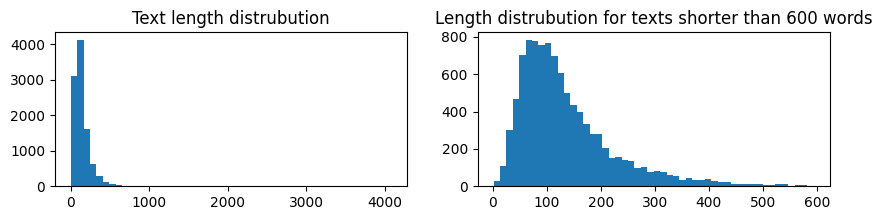

In [5]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Text length distrubution')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Length distrubution for texts shorter than 600 words')

plt.show()

We can see that texts are often quite long. So we can't cheat and before vectorization we will have to break each text into smaller chunks in order not to overload the model context and to avoid losing important information when vectorizing texts at the stage of a vector database creation.

Now, let's start implementing RAG.

## Retrieval‑Augmented Generation

Take the [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) model from huggingface as the LLM for the assistant. Note that this is an `Instruct` model, so it is intended for dialog-type communication.

__Task 0 [0.5 pts]__ Check how the model answers on cooking questions without RAG. This is always the first step to check if is worth putting effort in RAG implementation.

In [ ]:
# your code here

### Locality Sensitive Hashing (LSH)

In RAG, for each query, we search for relevant documents in a vector database. Since there are a lot of documents, calculating the relevance for each document is very time consuming. Therefore, it is important to make the search fast. To achieve this, we are even OK with sacrificing a bit of accuracy.

In this section you will implement [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing)

The idea behind LSH is quite simple. Let's divide all vectors from the database into groups consisting of similar vectors. At the start of the search, we will find a group that corresponds to the query vector and then calculate relevance only for the vectores in this group. To split vectors into groups we will introduce several hash functions. Each of them will be built according to the following algorithm:
1. Generate $k$ random vectors (normal vectors of the hyperplane)
2. For an individual point (vector) in the database and the normal vector, we will write 1 if the point lies above the corresponding hyperplane. In the opposite case, we will write 0.
3. Repeat the procedure for all points and normal vectors. Then for each point we will get a list of $k$ 0 and 1, which will be the hash.
4. Save which points correspond to which hash.
5. Repeat steps 1-4 $L$ times and get $L$ different hash tables.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

Now for each new vector $q$ we can very quickly find a set of vectors similar to it. To do this, we will count the query's hashes for each hash table and take all points whose hash matches $q$'s in at least one of hash tables. Then we re-rank the found points by relevance (distance to the query vector) and keep a given number of the closest ones.

The complexity of hash table generation can be estimated as $O(nLkd)$, where $n$ is the number of vectors in the database and $d$ is the dimensionality of the vector. At the same time, the complexity of LSH search is $O(Lkd + (nLp) \cdot d)$, where $p$ is the probability that the hashes of two random points will match ($p$ tends to 0). The complexity of the full search is $O(nd)$, so LSH search is almost $\frac{n}{Lk}$ times faster!

__Task 1 [3.5 pts]__ Implement a vector database with LSH search. The database should be able to add new vectors, as well as quickly find the closest vectors to the input vector. While creating the database, generate the required number of hash functions. Think about how to choose the number of hash tables and the number of random vectors, as well as the distribution from which to take these random vectors. When adding a new vector to the database, find its hash and record which groups it belongs to.

Try to optimize your code and don't forget to test that your LSH works as it should. The easiest way to do this is to build the database with two-dimensional points and visualize the results. Also compare the speed of the LSH search with a brute force search. If you've done everything right, you should get a speedup of about 4 times for 1000 points.

In [7]:
# your code here

### Splitting text into chunks

Since some texts are rather long, if we encode them with one vector, some information will be lost. A vector has a limited size after all. To avoid losing information, we will divide the text into chunks and encode each chunk separately.

__Task 2 [2.5 pts].__ Implement [recursive splitting](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) of text with splitting characters `["\n\n\n", "\n\n", " ", ""]`. Add an overlap between chunks for `[" ", ""]` characters. That is, if a whole paragraph fits in one chunk, you don't need to add overlap for it (it contains a complete idea), but if the paragraph doesn't fit and has to be divided by words (or characters), you need to add an overlap with words from neighboring chunks of the same paragraph.

Select the values for the maximum size of each chunk and the size of the overlap yourself. It is common to take the overlap size equal to half the size of the chunk.

In [ ]:
# your code here

## RAG

Finally we can start building the RAG system. First, let's create a vector database from chunks of recipes. To get chunk embedding take the model [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), it is created specially for this task and works well with Russian language.

__Task 3 [1 pts].__ Build a vector database using the functions you have written. The process should not take much time with GPU, but we recommend saving the result to disk so that you don't vectorize the whole dataset again when restarting the kernel. Check that for different queries relevant texts are returned.

In [ ]:
# your code here

### Prompt formation and response generation

Of all the RAG components, building this one requires the most creativity. You have to come up with a prompt format that will help the model generate an answer.

__Task 4 [1.5 pts]__ Write a function to generate a response to a text query in the RAG paradigm. Find relevant documents and build a prompt using them wich addition of instructions for the model explaining what it is required to do. Limit the number of texts in the prompt by selecting the top most relevant ones. Note that our dataset has a list of ingredients and the name of the dish in addition to the recipe. Think about how these can be used. Feed the prompt into the model to generate the answer. Choose the generation hyperparameters to control the generation diversity. Remember that the model must strictly follow the instructions, not make up facts or generate anything it is not required to do.

In [8]:
# your code here

__Task 5 [1 pts]__ Demonstrate the performance of your RAG assistant in a variety of scenarios (different question topics, different difficulty). Give examples of both successful and unsuccessful answers. Why doesn't your system always work properly? What are its limitations and what are the advantages? What do you think could be done to improve it?